# 1. Importing libraries

In [1]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *

# 2. Data loading

In [3]:
df = pd.read_csv('../data/processed/products.csv', index_col=0)

df.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,Furniture,Furnishings,2,159.120,3,60.390,10.14
FUR-ADV-10000108,Furniture,Furnishings,3,350.070,7,3.360,22.90
FUR-ADV-10000183,Furniture,Furnishings,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,Furniture,Furnishings,5,124.950,7,4.200,16.53
FUR-ADV-10000190,Furniture,Furnishings,1,222.360,2,104.460,32.71


# 3. Preprocessing

* Remove the columns we do not want to consider.

    - In this case, we are not going to remove any columns.

* Select the encoding methods for categorical variables.

    - We only have the categorical variables `Category` and `Sub-Category`. We will perform a Frequency Encoding for both of them.

* Select the scaling method.

    - We will initially try using a RobustScaler due to the significant presence of outliers.

In [9]:
cols = []

encoding_methods = {"frequency": ['Category', 'Sub-Category']}

scaling = 'robust'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=cols)

In [10]:
df_encoded.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,0.216479,0.066459,2,159.120,3,60.390,10.14
FUR-ADV-10000108,0.216479,0.066459,3,350.070,7,3.360,22.90
FUR-ADV-10000183,0.216479,0.066459,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,0.216479,0.066459,5,124.950,7,4.200,16.53
FUR-ADV-10000190,0.216479,0.066459,1,222.360,2,104.460,32.71


In [11]:
df_scaled.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,-1.044357,0.52,-0.4,-0.251171,-0.705882,0.134199,-0.298725
FUR-ADV-10000108,-1.044357,0.52,-0.2,-0.091262,-0.470588,-0.203325,-0.196204
FUR-ADV-10000183,-1.044357,0.52,0.8,0.431936,0.941176,-4.080435,0.423421
FUR-ADV-10000188,-1.044357,0.52,0.2,-0.279786,-0.470588,-0.198354,-0.247384
FUR-ADV-10000190,-1.044357,0.52,-0.6,-0.198211,-0.764706,0.395021,-0.117385


# 4. Clustering

We are going to implement different clustering algorithms to see how the products are segmented.

## 4.1 K-means

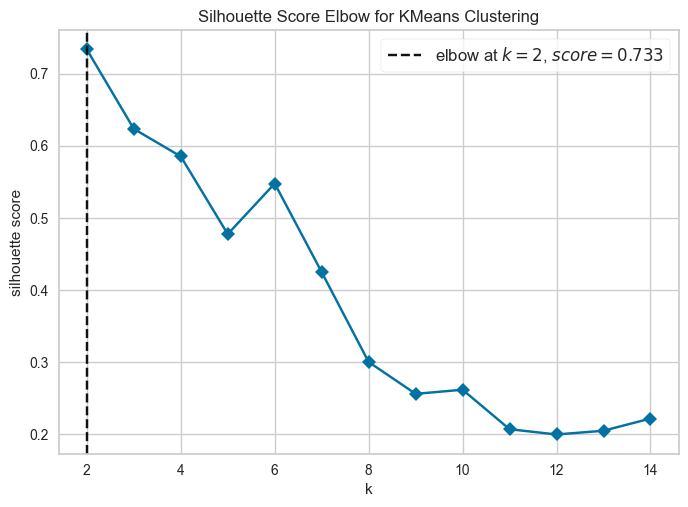

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [12]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

Using the elbow technique and the selected preprocessing, we obtain two clusters, $k = 2$, and a silhouette score of 0.733 (close to 1).  

This means that the data appear to group well into two clusters and that there is no significant overlap between them.

In [13]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### 4.1.1 Metrics

In [14]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.730903,0.738907,565
1,0.730903,0.738907,9727


We observe a Davies-Bouldin index of 0.74, which falls between 0 and 1, indicating moderately adequate cluster compactness and separation (close to 0 is better).

Looking at the cardinality, both clusters have a good amount of data, although one is significantly larger than the other.

### 4.1.2 Cluster exploration

In this section, we will compare the obtained clusters to identify their properties.

In [15]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

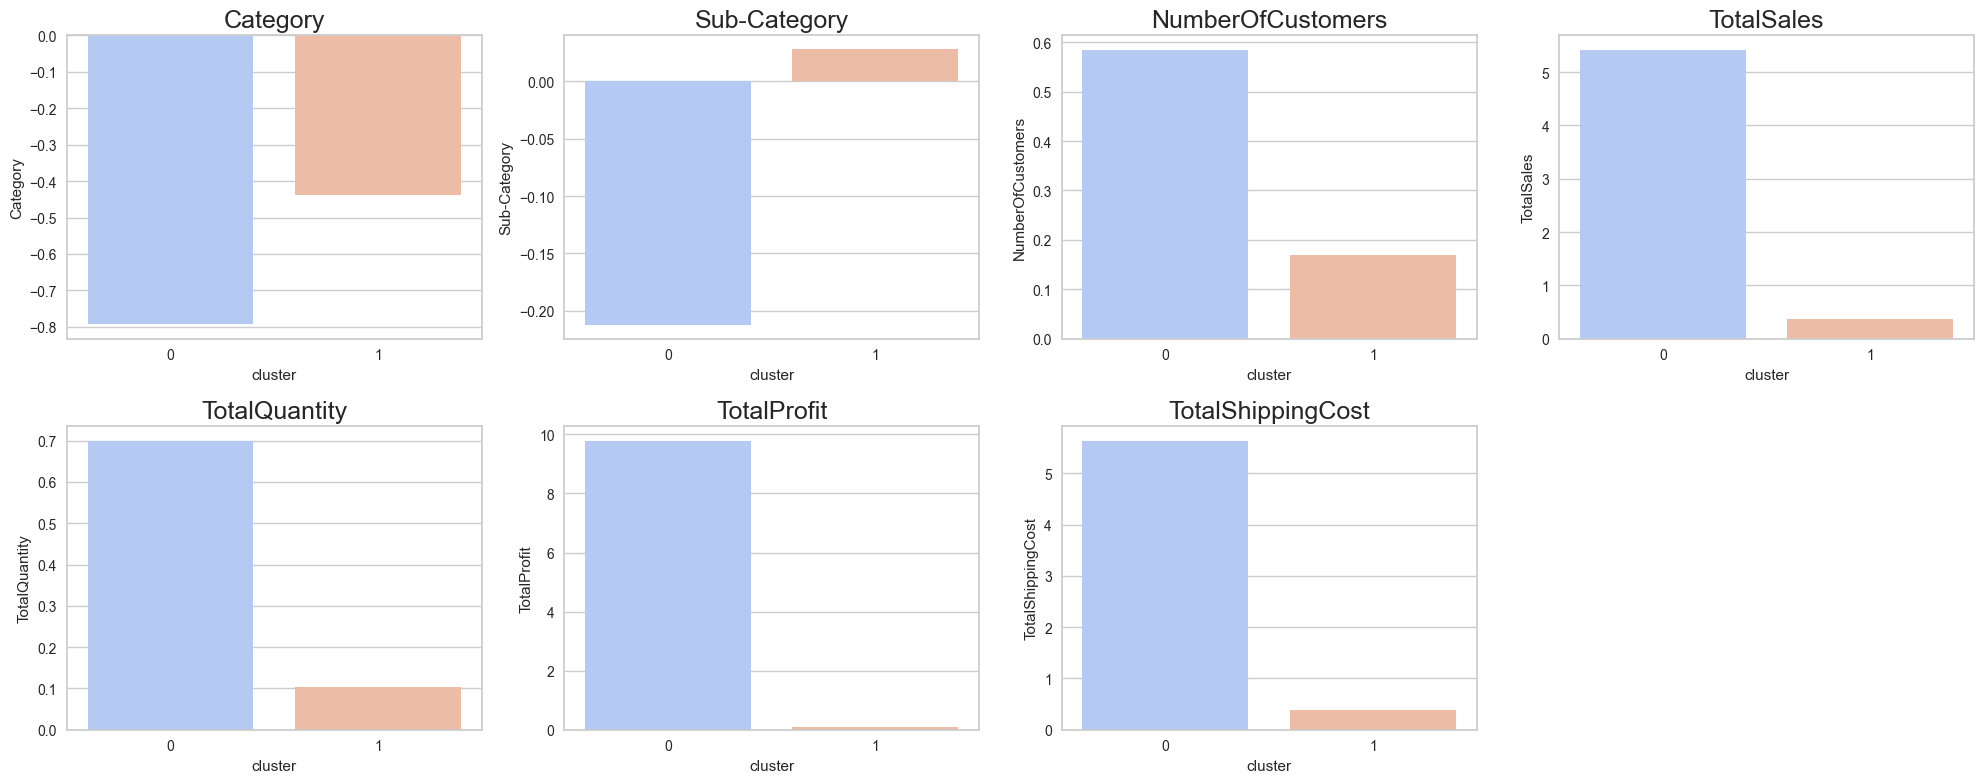

In [16]:
plot_clusters(df_kmeans)

In this case, the segmentation seems to occur based on both category and subcategory, as well as total sales (and other monetary variables).  

It appears that one cluster generates significantly higher sales, while the other has a much lower amount.

#### Radar plot

By creating a radar chart, we can also examine the differences between clusters.

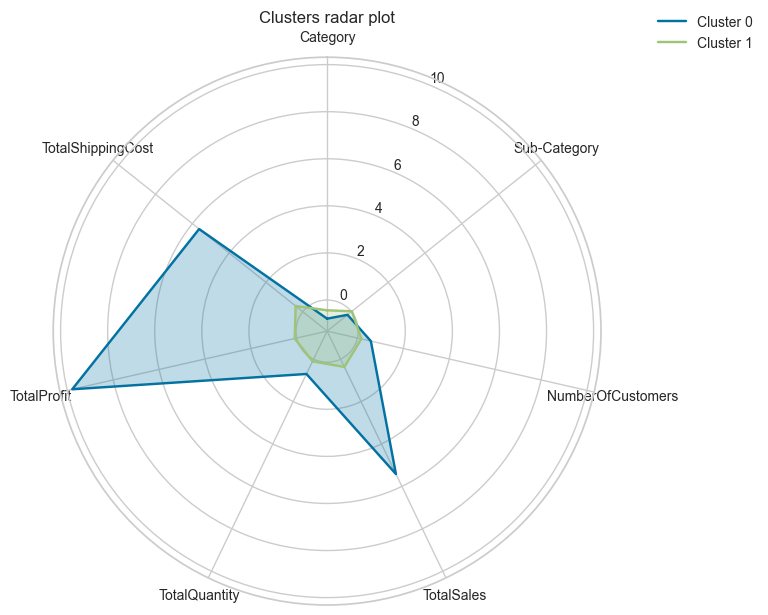

In [19]:
# Select variables to display in radar plot
variables = ['Category', 'Sub-Category', 'NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_kmeans, variables)

#### Histograms

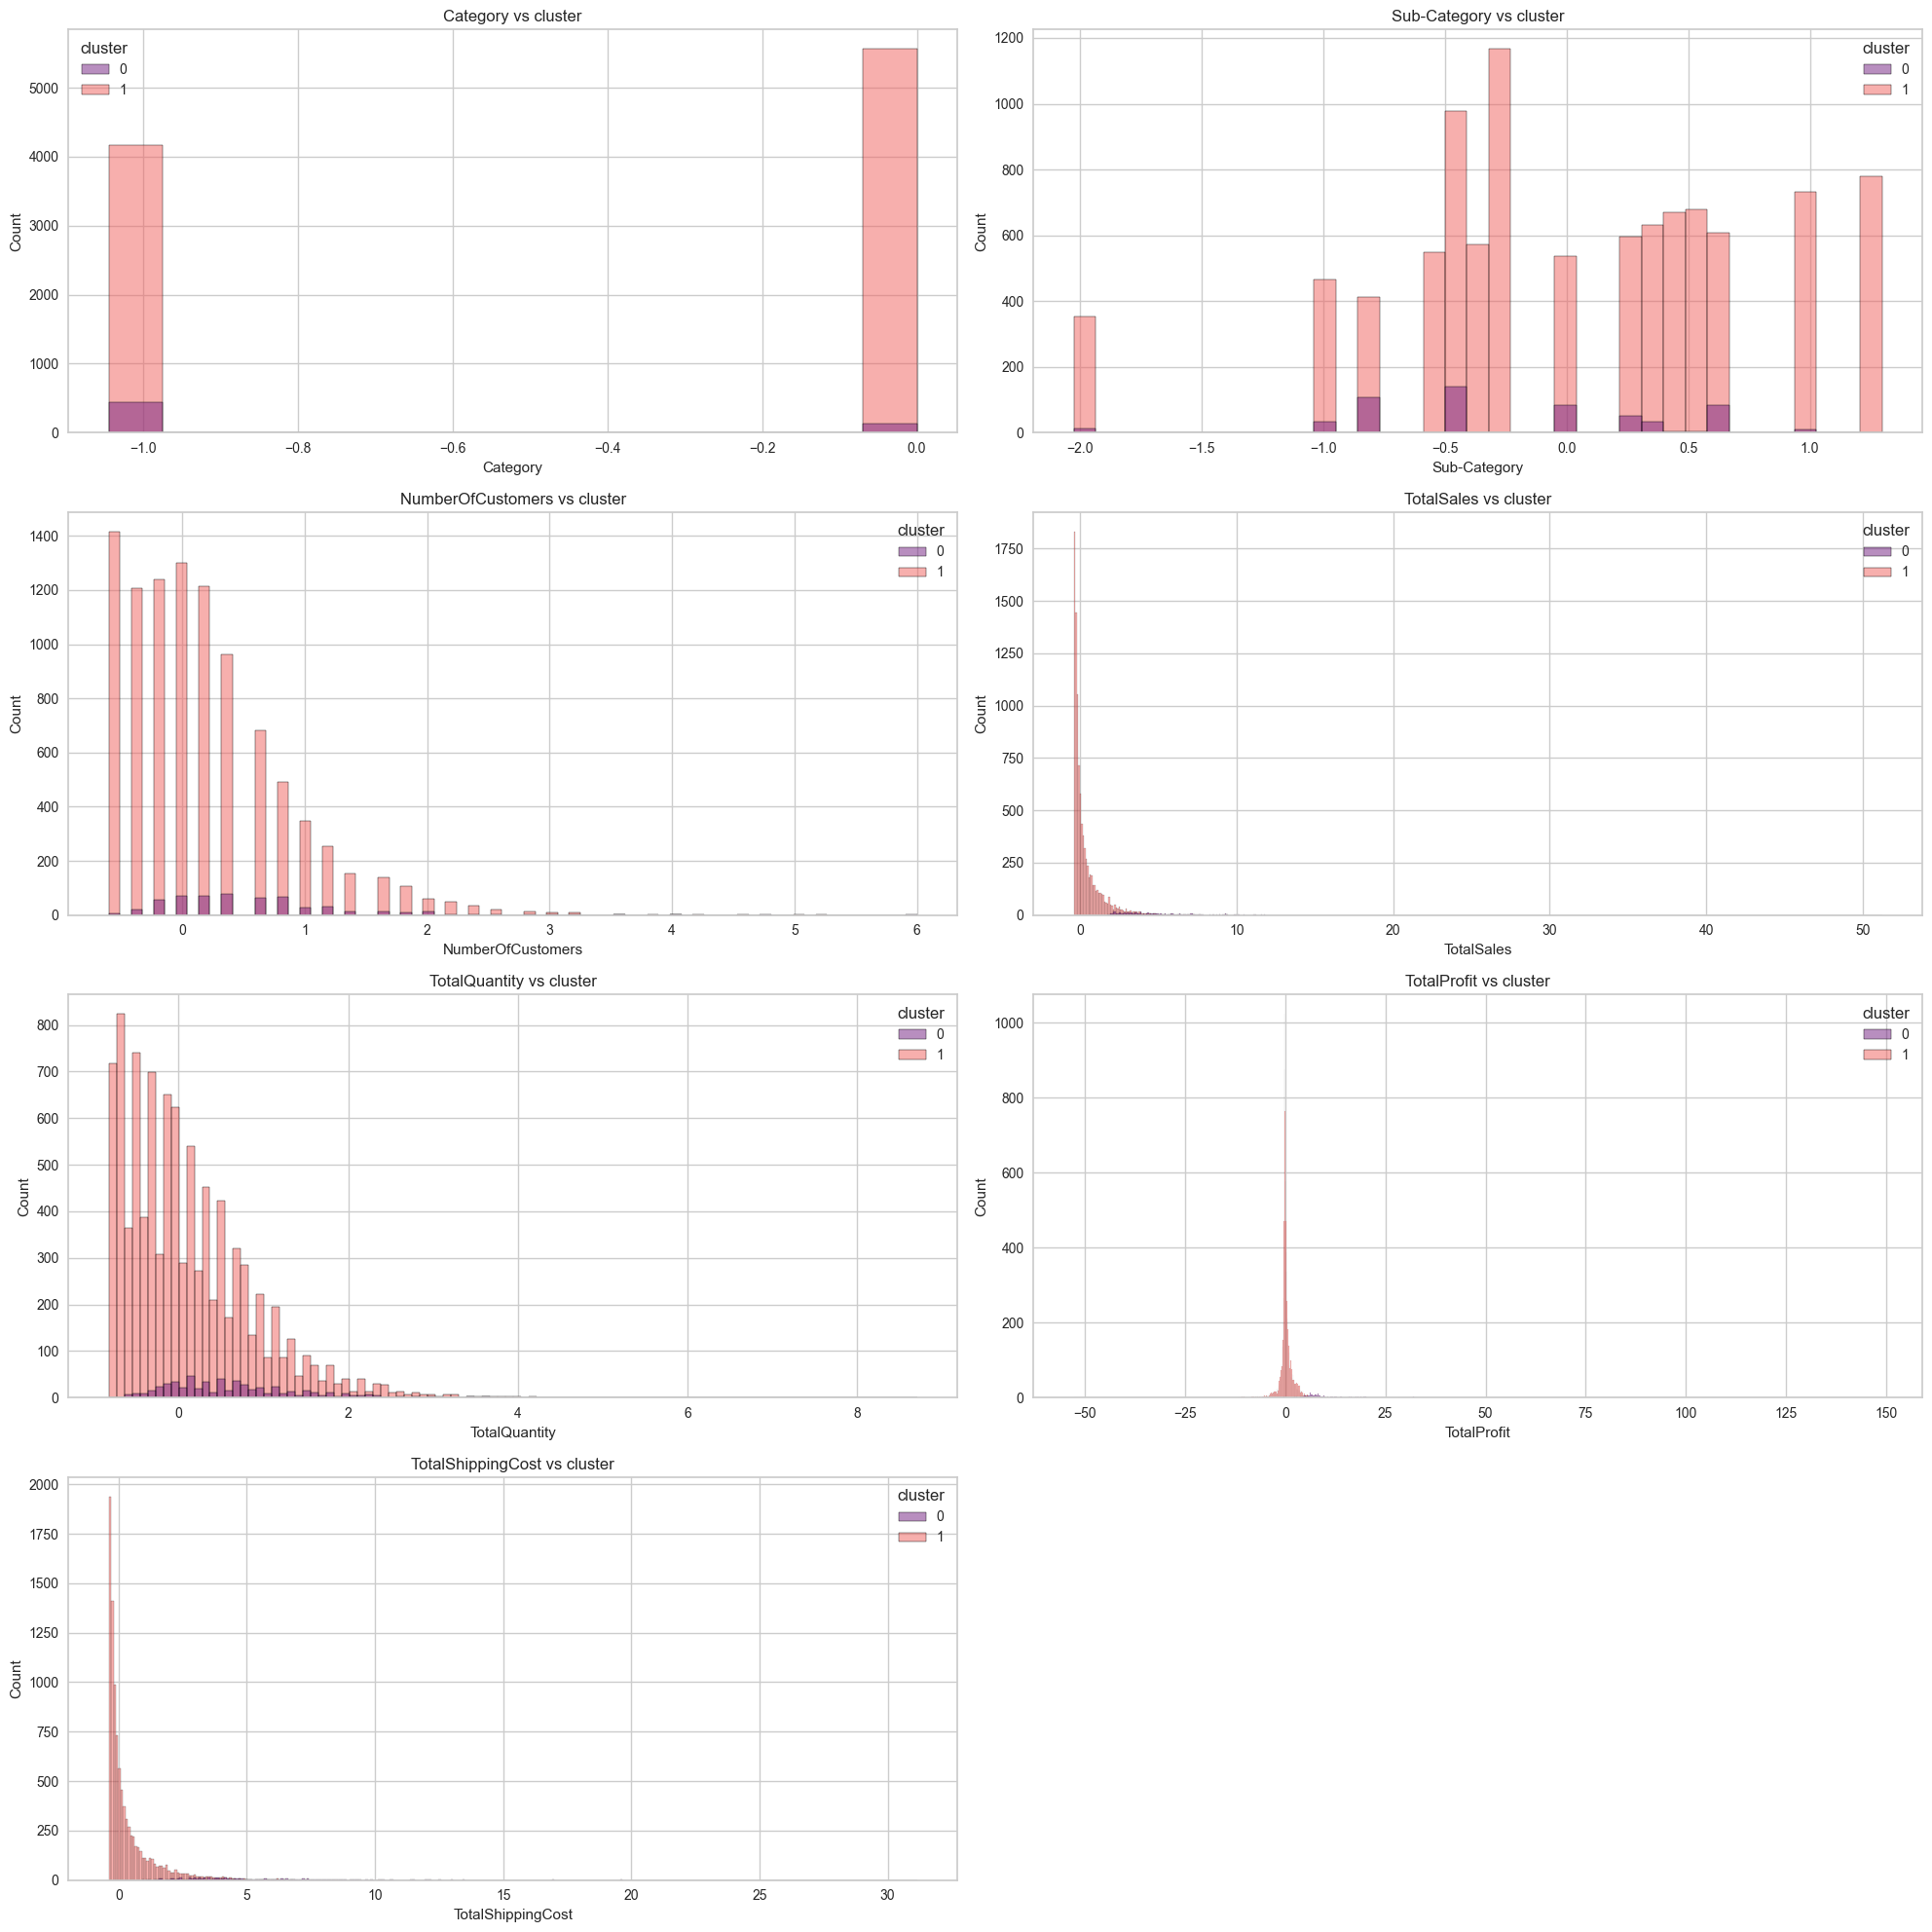

In [20]:
plot_relation_tv(df_kmeans, 'cluster', size=(20, 20), n_cols = 2)

There does not seem to be a clear division of the data beyond products with higher or lower sales.

## 4.2 Agglomerative clustering

This time, we will use an agglomerative hierarchical clustering model.  

Let’s start by visualizing the dendrograms associated with each type of linkage we can use.

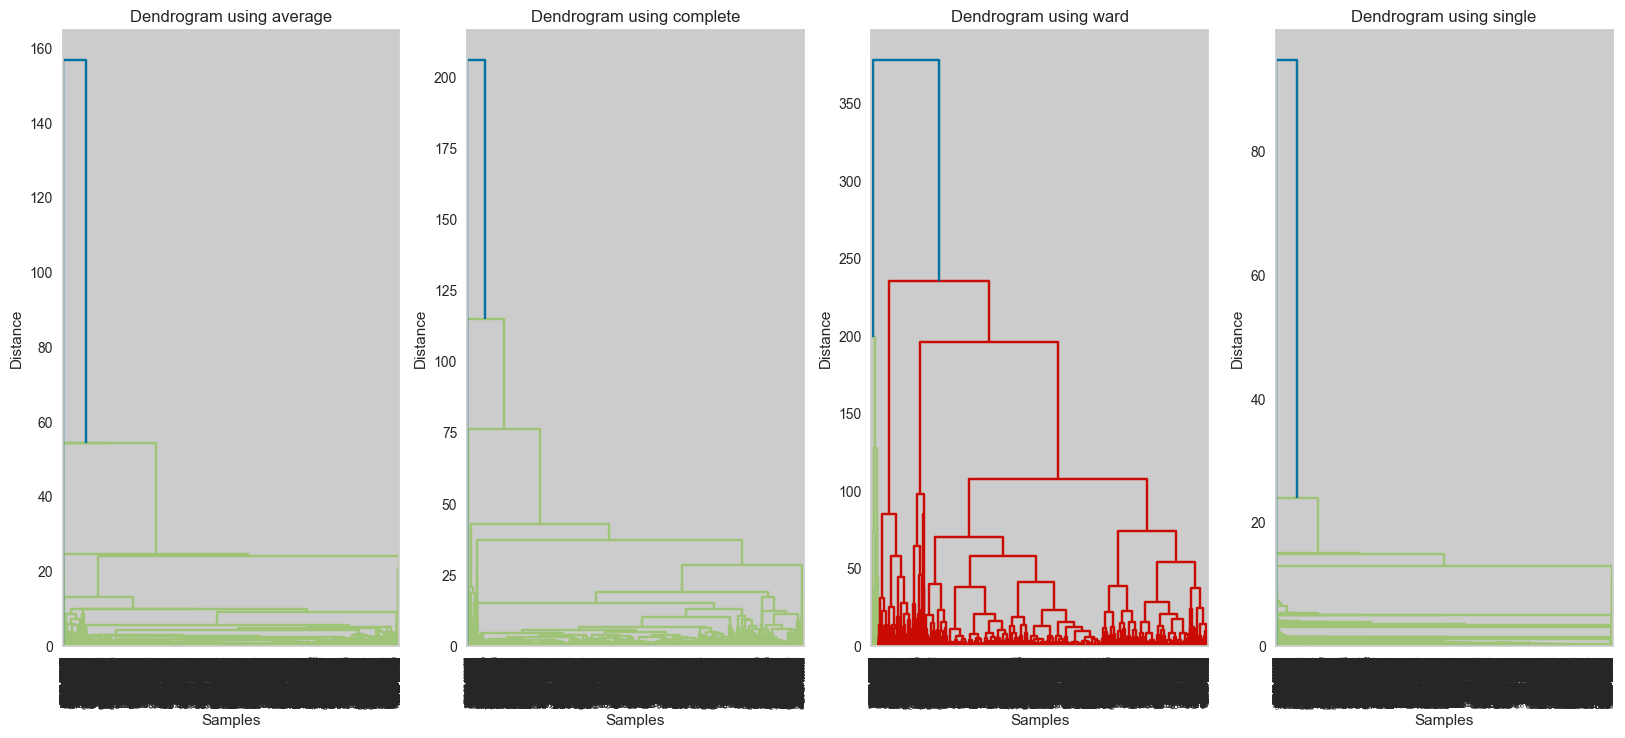

In [21]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [22]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [27]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                                    complete
metric                                       cosine
silhouette_score                            0.34397
davies_bouldin_index                       1.606845
cluster_cardinality     {0: 5524, 1: 2533, 2: 2235}
n_cluster                                         3
balance_score                              2.471588
ranking_score                             -3.734463
Name: 5, dtype: object

The best model uses a 'complete' linkage, a Cosine metric, and this time, 3 clusters.

In [28]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

### 4.2.1 Metrics

In [29]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,-0.036565,1.606845,5524
1,-0.036565,1.606845,2533
2,-0.036565,1.606845,2235


However, this time the metrics are not very good. Although the clusters are fairly balanced in terms of cardinality, the metrics do not indicate a good level of grouping and differentiation between them.

### 4.2.2 Cluster exploration

In [30]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

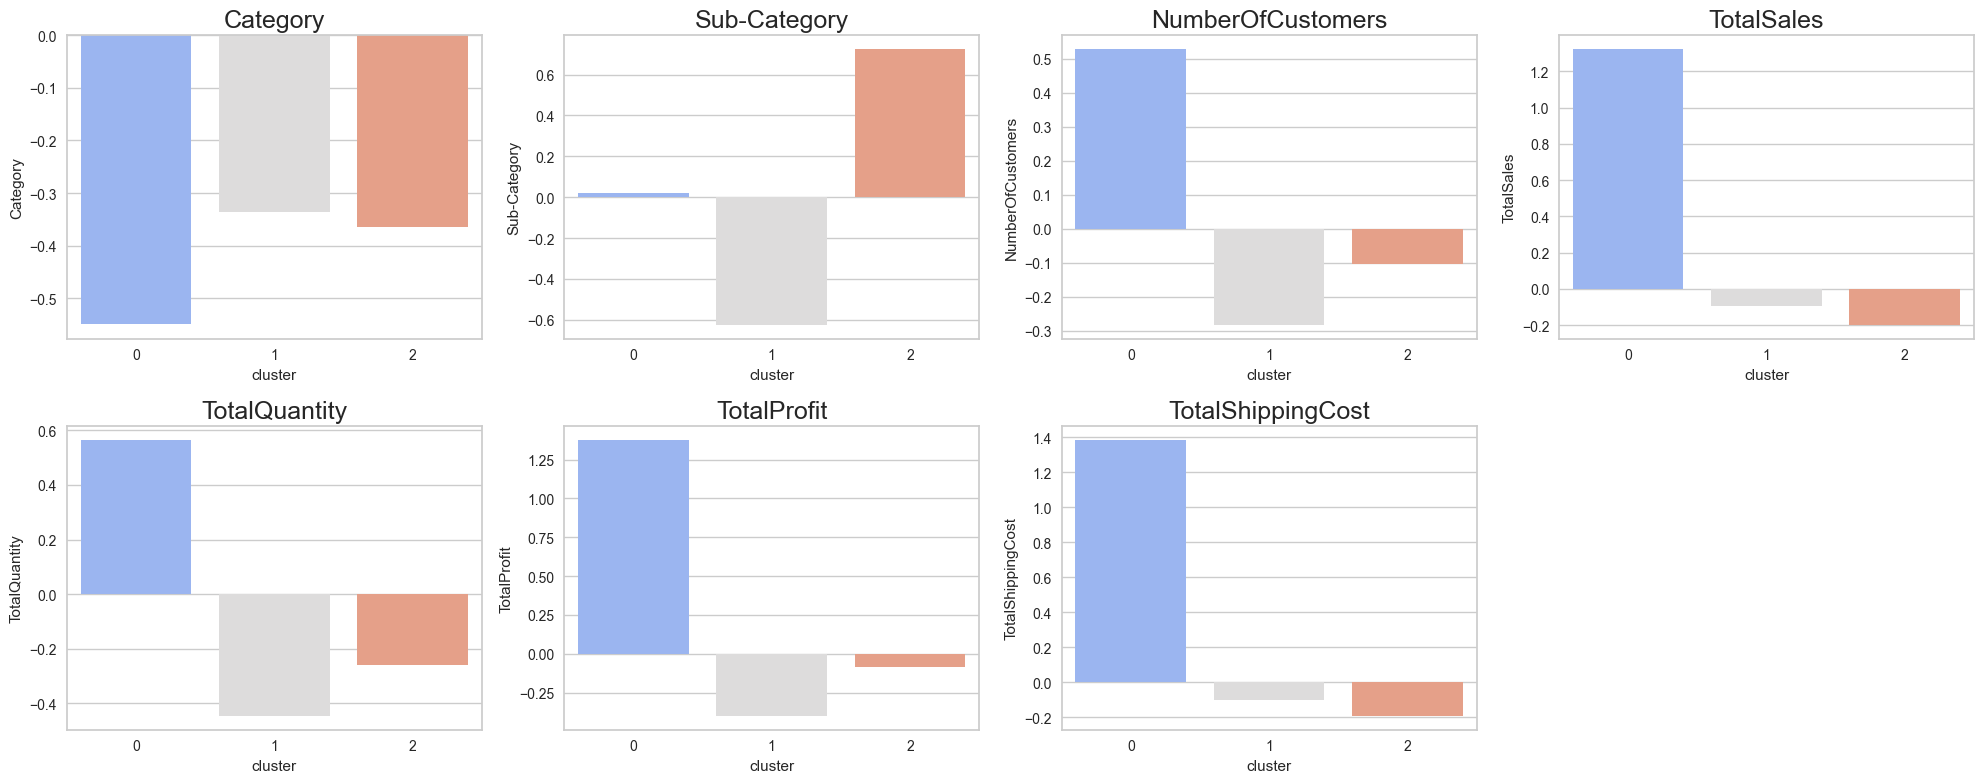

In [31]:
plot_clusters(df_agg)

#### Radar plot

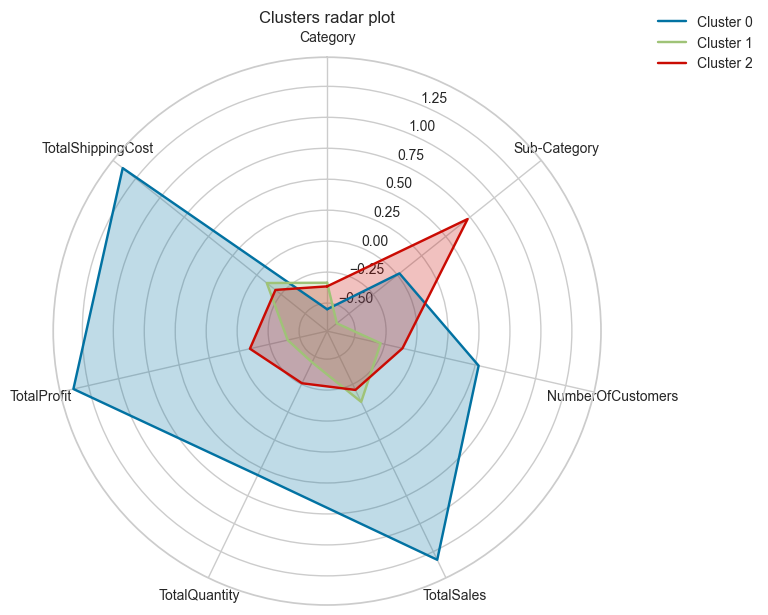

In [33]:
# Select variables to display in radar plot
variables = ['Category', 'Sub-Category', 'NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_agg, variables)

#### Histograms

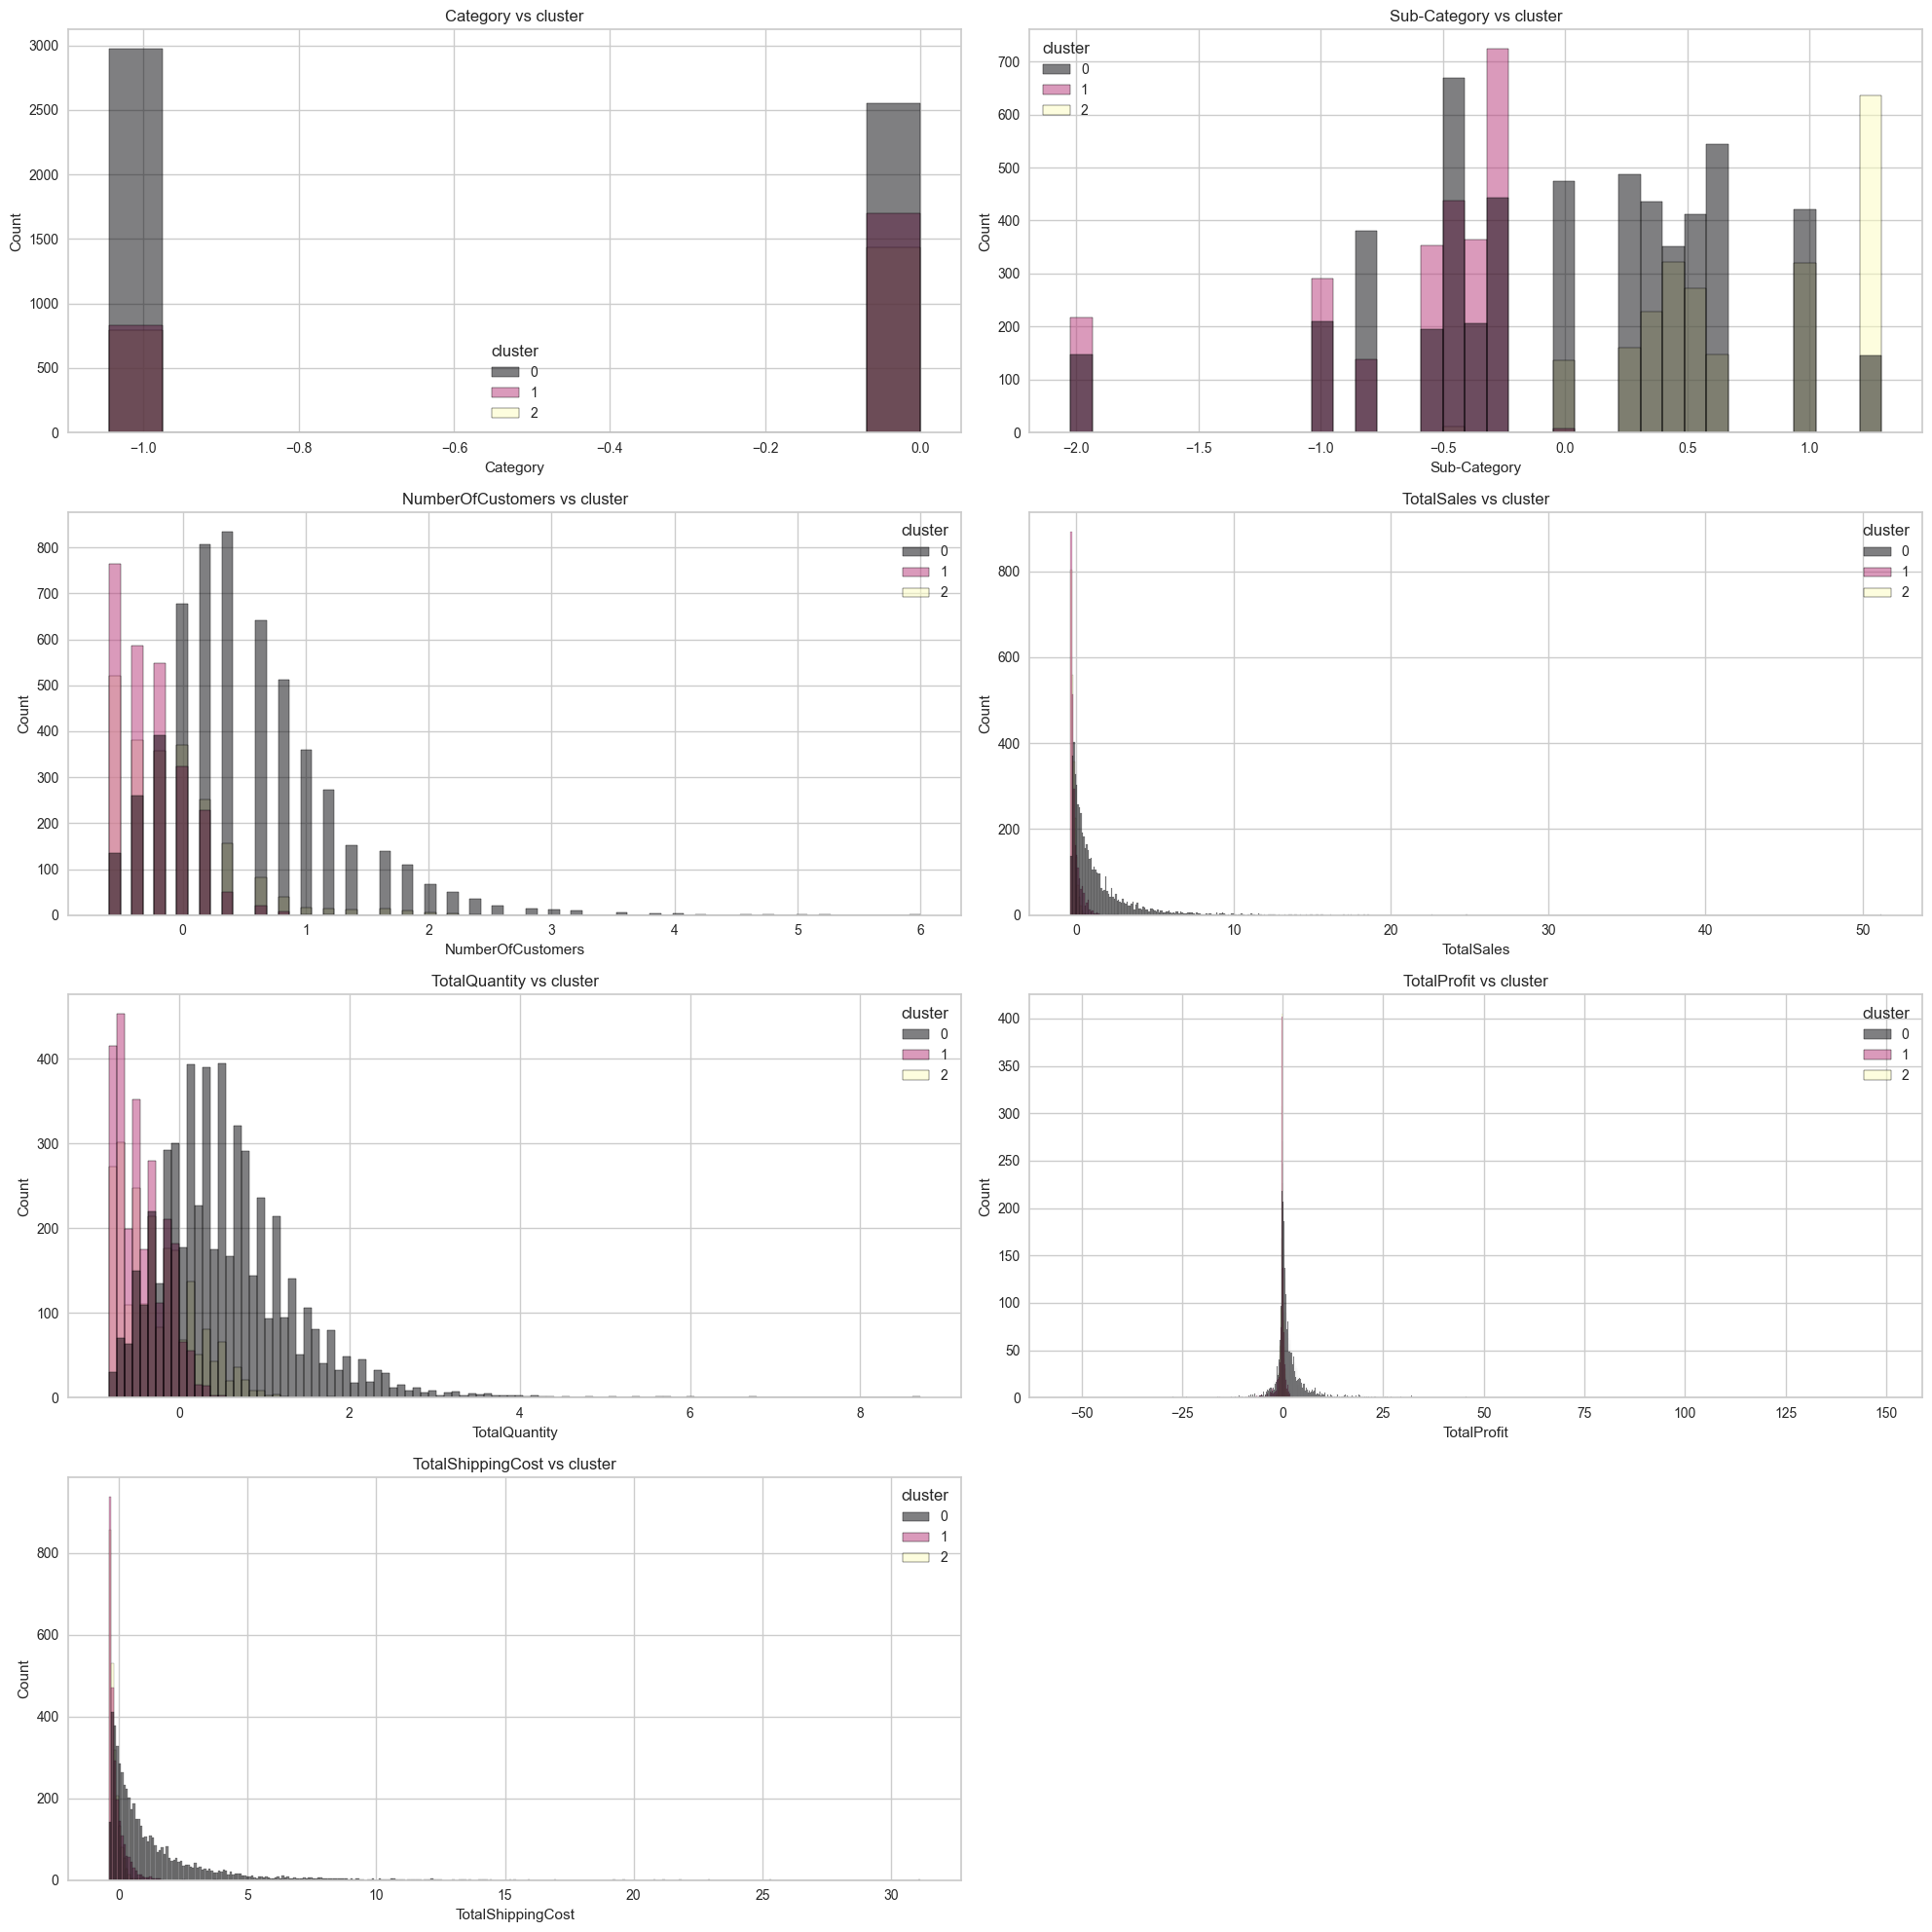

In [34]:
plot_relation_tv(df_agg, 'cluster', size=(20,20), n_cols = 2)

It seems again that we have one product cluster with higher sales capacity and two more diffuse clusters, whose main differences appear to be subcategories within a category.

## 4.3 Spectral clustering

This method takes a long time to run on this dataset, so we will discard it for now.

## 4.4 DBSCAN Clustering

Next, let’s test the DBSCAN method with different values of epsilon and min_samples.

In [45]:
dbscan_methods(df_scaled, eps_values=[0.1, 1, 10, 20], min_samples_values=[3, 5, 10, 15])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
12,20.0,3,0.960696,1.882380,"{-1: 2, 0: 10290}"
13,20.0,5,0.960696,1.882380,"{-1: 2, 0: 10290}"
14,20.0,10,0.954845,1.307462,"{-1: 3, 0: 10289}"
15,20.0,15,0.945259,0.957931,"{-1: 5, 0: 10287}"
8,10.0,3,0.939218,0.760270,"{-1: 7, 0: 10285}"
9,10.0,5,0.939218,0.760270,"{-1: 7, 0: 10285}"
10,10.0,10,0.931132,1.182855,"{-1: 9, 0: 10283}"
11,10.0,15,0.928065,1.430098,"{-1: 10, 0: 10282}"
7,1.0,15,0.129909,1.880681,"{-1: 1487, 0: 3371, 1: 202, 2: 5232}"
6,1.0,10,0.100343,2.039984,"{-1: 1299, 0: 3466, 1: 214, 2: 31, 3: 5282}"


After testing multiple combinations of `epsilon` and `min_samples`, we concluded that the only clusterings with acceptable metrics are two-group clusters, with one of the groups being extremely small.  

This is not necessarily a bad thing; it is possible that there is some real meaning behind this clustering, so we could explore it further in the future.  

For now, we will discard the DBSCAN method for clustering.

# 5 Conclusions

We have obtained different results using the various clustering algorithms. The only one that provided clusters with good metrics, meaning significantly well-defined clusters, is K-Means.  

In this case, we obtained only two clusters, whose main difference appears to lie in the sales generated by these products.  

In the next Jupyter Notebook, we will apply a different preprocessing approach to obtain a clustering model that provides more valuable insights and allows us to perform a more suitable product segmentation.